<a href="https://colab.research.google.com/github/nitaymayo/My_Portfolio/blob/main/AI/Tensorflow/NLP_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Models Notebook

A number of experiments that ment to train and test models on the task of classify tweets to 2 groups:
<ul>
  <li>Tweets that talk about disasters</li>
  <li>Regular day to day tweets</li>
</ul>

In [ ]:
! nvidia-smi

Sun Jan 22 20:16:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import *

--2023-01-22 20:16:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-22 20:16:34 (85.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import tensorflow as tf

## Data Preperation

In [ ]:
! wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data("nlp_getting_started.zip")

--2023-01-22 20:16:41--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2023-01-22 20:16:41 (60.7 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/train.csv")

test_df = pd.read_csv('/content/test.csv')


train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

## Visualization

In [ ]:
shuffled_train_df = train_df.sample(frac=1, random_state=42)

In [ ]:
shuffled_train_df[["target", "text"]]

,target,text
2644,1,So you have a new weapon that can cause un-ima...
2227,0,The f$&amp;@ing things I do for #GISHWHES Just...
5448,1,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
132,0,Aftershock back to school kick off was great. ...
6845,0,in response to trauma Children of Addicts deve...
...,...,...
5226,0,@Eganator2000 There aren't many Obliteration s...
5390,0,just had a panic attack bc I don't have enough...
860,0,Omron HEM-712C Automatic Blood Pressure Monito...
7603,1,Officials say a quarantine is in place at an A...


In [ ]:
import random
index = random.randint(0, (len(train_df)-5))
for _, target, text in shuffled_train_df[["target", "text"]][index:(index+5)].itertuples():
  print('\ntarget:', "Disaster" if target == 1 else "Not a disaster")
  print(f"text:\n{text}\n")
  print("______\n")


target: Disaster
text:
Japan FUSO Class Battleship YAMASHIRO Naval Cover 1999 PHOTO Cachet SUNK WWII http://t.co/Aq5ZliM7l4 http://t.co/FvR9jDQ71a

______


target: Disaster
text:
Tension In Bayelsa As Patience Jonathan Plans To Hijack APC PDP http://t.co/qxXN6RKsp6 http://t.co/B3X1wqzAoR

______


target: Disaster
text:
#???? #?? #??? #??? Trains derailment: 'It's the freakiest of freak accidents' - The Indian Express   http://t.co/4Y4YtwhD74

______


target: Disaster
text:
Chevrolet : Avalanche LT 2011 lt used 5.3 l v 8 16 v automatic 4 wd pickup truck premium bÛ_ http://t.co/OBkY8Pc89H http://t.co/dXIRnTdSrd

______


target: Disaster
text:
#TRAFFICALERT  Eastbound 210 Freeway at Citrus Ave in Azusa. Two motorcycles involved in accident with one fully engulfed in flames in lanes

______



## Create Validation split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(shuffled_train_df["text"].to_numpy(),
                                                                            shuffled_train_df["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
 val_sentences[:10], val_labels[:10]

(array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
        'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
        'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
        "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over so

## Creatring text vectorizer


In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
max_tokens = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
sample_sentence = "There is a dog on the table"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  74,    9,    3,  957,   11,    2, 2663,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
random_sentence = random.choice(train_sentences)

print("original:\n", random_sentence)
print("vectorized:\n", text_vectorizer([random_sentence]))

original:
 Man Currensy really be talkin that talk... I'd be more devastated if he had a ghostwriter than anybody else....
vectorized:
 tf.Tensor(
[[  89    1  169   21 4473   16  833  508   21   51  901   47   56   94
     3]], shape=(1, 15), dtype=int64)


In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print("number of words:", len(words_in_vocab))
print("top 5 words: ", top_5_words)
print("bottom 5 words: ", bottom_5_words)

number of words: 10000
top 5 words:  ['', '[UNK]', 'the', 'a', 'in']
bottom 5 words:  ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=len(words_in_vocab),
                            output_dim=128,
                            input_length=max_length)

In [ ]:
random_sentence = random.choice(train_sentences)

print("Original:\n", random_sentence)

print("Embaded:\n", embedding(text_vectorizer(random_sentence)))

Original:
 Obama Declares Disaster for Typhoon-Devastated Saipan http://t.co/CanEyTtwEV #international
Embaded:
 tf.Tensor(
[[-0.02519499 -0.0275258   0.02813746 ... -0.0394666  -0.04616515
  -0.04508202]
 [ 0.01205381  0.02337429  0.01003974 ... -0.03134548  0.03901773
  -0.00513036]
 [ 0.02005457 -0.03225052  0.01810891 ...  0.03667129 -0.02527994
  -0.0268201 ]
 ...
 [ 0.01682066  0.01250679  0.02928312 ... -0.02166585 -0.00517759
  -0.00512512]
 [ 0.01682066  0.01250679  0.02928312 ... -0.02166585 -0.00517759
  -0.00512512]
 [ 0.01682066  0.01250679  0.02928312 ... -0.02166585 -0.00517759
  -0.00512512]], shape=(15, 128), dtype=float32)


# Creating the model and Start Experiminets

## Model 0 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print("baseline score:", baseline_score)

baseline score: 0.7926509186351706


In [ ]:
baseline_preds = model_0.predict(val_sentences)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, precision_recall_fscore_support
def evaluation_dictonary(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)

  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  print(precision)
  # percision = precision_score(y_true, y_pred)

  # recall = recall_score(y_true, y_pred)

  # f1 = f1_score(y_true, y_pred)

  return {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1
  }

In [ ]:
baseline_results = evaluation_dictonary(baseline_preds, val_labels)
baseline_results

0.8336022277575122


{'accuracy': 0.7926509186351706,
 'precision': 0.8336022277575122,
 'recall': 0.7926509186351706,
 'f1_score': 0.7990828614653861}

## Model 1

### Callbacks

In [ ]:
SAVE_DIR = "models_logs"
tnesorboard_callback = create_tensorboard_callback(dir_name=SAVE_DIR,
                                                   experiment_name='Simple_dense_model')

Saving TensorBoard log files to: models_logs/Simple_dense_model/20230122-201826


### Build

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

In [ ]:
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

###Train

In [ ]:
model_1_history = model_1.fit(x=train_sentences,
            y=train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[tnesorboard_callback])

Epoch 1/5
215/215 [==============================] - 8s 29ms/step - loss: 0.6124 - accuracy: 0.6843 - val_loss: 0.5362 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.4415 - accuracy: 0.8189 - val_loss: 0.4733 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.3469 - accuracy: 0.8631 - val_loss: 0.4624 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.2840 - accuracy: 0.8894 - val_loss: 0.4680 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2376 - accuracy: 0.9101 - val_loss: 0.4839 - val_accuracy: 0.7900


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4839 - accuracy: 0.7900


[0.48385220766067505, 0.7900262475013733]

In [ ]:
model_1_preds = tf.squeeze(tf.round(model_1.predict(val_sentences)))

24/24 [==============================] - 0s 2ms/step


In [ ]:
model_1_preds[:15]

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)>

In [ ]:
model_1_results = evaluation_dictonary(val_labels, model_1_preds)
model_1_results

0.7964718621790533


{'accuracy': 0.7900262467191601,
 'precision': 0.7964718621790533,
 'recall': 0.7900262467191601,
 'f1_score': 0.7866259949990327}

In [ ]:
embed_weights = model_1.get_layer('embedding').get_weights()[0]

In [ ]:
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [ ]:
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Model 2: LTSM

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64)(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs)


In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________

In [ ]:
model_2.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              validation_data=(val_sentences, val_labels),
                              epochs=5,
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: models_logs/model_2_LSTM/20230121-070914
Epoch 1/5
215/215 [==============================] - 18s 55ms/step - loss: 0.2175 - accuracy: 0.9210 - val_loss: 0.5545 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.1548 - accuracy: 0.9447 - val_loss: 0.6643 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.1276 - accuracy: 0.9526 - val_loss: 0.7566 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1033 - accuracy: 0.9600 - val_loss: 0.8096 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0848 - accuracy: 0.9657 - val_loss: 0.9004 - val_accuracy: 0.7717


In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2.predict(val_sentences)))
model_2_preds[:10]

24/24 [==============================] - 1s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_2_results = evaluation_dictonary(val_labels, model_2_preds)
model_2_results

0.7747861668850706


{'accuracy': 0.7716535433070866,
 'precision': 0.7747861668850706,
 'recall': 0.7716535433070866,
 'f1_score': 0.7688960790251899}

## Model 3:GRU

In [ ]:
from tensorflow.keras import layers
inputs = tf.keras.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________

In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              validation_data=(val_sentences, val_labels),
                              epochs=5,
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: models_logs/model_3_GRU/20230121-071001
Epoch 1/5
215/215 [==============================] - 9s 30ms/step - loss: 0.1533 - accuracy: 0.9428 - val_loss: 0.7005 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0806 - accuracy: 0.9705 - val_loss: 0.7463 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0696 - accuracy: 0.9745 - val_loss: 0.9337 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0601 - accuracy: 0.9734 - val_loss: 1.2247 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0519 - accuracy: 0.9769 - val_loss: 1.1668 - val_accuracy: 0.7703


In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3.predict(val_sentences)))

24/24 [==============================] - 1s 4ms/step


In [ ]:
model_3_results = evaluation_dictonary(val_labels, model_3_preds)
model_3_results

0.7718252603398367


{'accuracy': 0.7703412073490814,
 'precision': 0.7718252603398367,
 'recall': 0.7703412073490814,
 'f1_score': 0.7683227325217538}

## Model 4: Bidirectional

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, outputs)

In [ ]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [ ]:
model_4.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidir")])

Saving TensorBoard log files to: models_logs/model_4_bidir/20230121-071046
Epoch 1/5
215/215 [==============================] - 13s 43ms/step - loss: 0.1189 - accuracy: 0.9622 - val_loss: 0.9291 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0528 - accuracy: 0.9783 - val_loss: 1.2409 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0474 - accuracy: 0.9784 - val_loss: 1.3013 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0410 - accuracy: 0.9804 - val_loss: 1.4172 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0372 - accuracy: 0.9807 - val_loss: 1.4791 - val_accuracy: 0.7638


In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4.predict(val_sentences)))
model_4_preds[:7]

24/24 [==============================] - 1s 7ms/step


<tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1.], dtype=float32)>

In [ ]:
model_4_results = evaluation_dictonary(val_labels, model_4_preds)
model_4_results

0.763377762834769


{'accuracy': 0.7637795275590551,
 'precision': 0.763377762834769,
 'recall': 0.7637795275590551,
 'f1_score': 0.7633188054110939}

## Model 5: Convoluition

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, kernel_size=5, activation="relu", strides=5, padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs)

In [ ]:
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 3, 64)             41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [ ]:
model_5.compile(loss='binary_crossentropy',
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_Conv")])

Saving TensorBoard log files to: models_logs/model_5_Conv/20230121-071133
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.1109 - accuracy: 0.9685 - val_loss: 0.8775 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0630 - accuracy: 0.9777 - val_loss: 1.0416 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0553 - accuracy: 0.9781 - val_loss: 1.0738 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0485 - accuracy: 0.9806 - val_loss: 1.1489 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0466 - accuracy: 0.9822 - val_loss: 1.1918 - val_accuracy: 0.7598


In [ ]:
model_5_preds = tf.squeeze(tf.round(model_5.predict(val_sentences)))

24/24 [==============================] - 0s 3ms/step


In [ ]:
model_5_results = evaluation_dictonary(val_labels, model_5_preds)
model_5_results

0.7615439957650938


{'accuracy': 0.7598425196850394,
 'precision': 0.7615439957650938,
 'recall': 0.7598425196850394,
 'f1_score': 0.7574575318690253}

## Model 6: Pretraind sentences encoder

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
embed_sample = embed([sample_sentence,
                     "I dont like tea"])

print(embed_sample[0][:50])

In [ ]:
sentence_embed_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      input_shape=[],
                                      dtype=tf.string,
                                      trainable=False,
                                      name="USE")

In [ ]:
from tensorflow.keras import layers
model_6 = tf.keras.Sequential([
    sentence_embed_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [ ]:
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_6.compile(loss='binary_crossentropy',
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              validation_data=(val_sentences, val_labels),
                              epochs=5,
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_6_USE_with_Dense")])

Saving TensorBoard log files to: models_logs/model_6_USE_with_Dense/20230122-201832
Epoch 1/5
215/215 [==============================] - 8s 13ms/step - loss: 0.5046 - accuracy: 0.7863 - val_loss: 0.4494 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4139 - accuracy: 0.8164 - val_loss: 0.4439 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4011 - accuracy: 0.8228 - val_loss: 0.4308 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3937 - accuracy: 0.8243 - val_loss: 0.4323 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3867 - accuracy: 0.8283 - val_loss: 0.4289 - val_accuracy: 0.8110


In [ ]:
model_6_preds = tf.squeeze(tf.round(model_6.predict(val_sentences)))

24/24 [==============================] - 1s 9ms/step


In [ ]:
model_6_results = evaluation_dictonary(val_labels, model_6_preds)
model_6_results

In [ ]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8336022277575122,
 'recall': 0.7926509186351706,
 'f1_score': 0.7990828614653861}

## Model 7: USE with 10% data

In [ ]:
# train_10_percent = shuffled_train_df[["text","target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()

In [ ]:
train_sentences_10_percent = train_sentences[:int(len(train_sentences) * 0.1)]
train_labels_10_percent = train_labels[:int(len(train_sentences) * 0.1)]

In [ ]:
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
dtype: int64

In [ ]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_10_percent_correct_split")])

Saving TensorBoard log files to: models_logs/model_7_10_percent_correct_split/20230121-071311
Epoch 1/5
22/22 [==============================] - 4s 48ms/step - loss: 0.6729 - accuracy: 0.6686 - val_loss: 0.6462 - val_accuracy: 0.7507
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.6024 - accuracy: 0.7912 - val_loss: 0.5912 - val_accuracy: 0.7717
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5316 - accuracy: 0.8029 - val_loss: 0.5393 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4704 - accuracy: 0.8234 - val_loss: 0.5050 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4287 - accuracy: 0.8350 - val_loss: 0.4924 - val_accuracy: 0.7769


In [ ]:
model_7_preds = tf.squeeze(tf.round(model_7.predict(val_sentences)))

24/24 [==============================] - 1s 11ms/step


In [ ]:
model_7_results = evaluation_dictonary(val_labels, model_7_preds)
model_7_results

0.7784265812728361


{'accuracy': 0.7769028871391076,
 'precision': 0.7784265812728361,
 'recall': 0.7769028871391076,
 'f1_score': 0.7750036673315875}

#Comparing the models

In [ ]:
all_models_results = pd.DataFrame({'baseline': baseline_results,
                                  '1_simple_dense': model_1_results,
                                  '2_LSTM': model_2_results,
                                  '3_GRU': model_3_results,
                                  '4_bidirectional': model_4_results,
                                  '5_conv': model_5_results,
                                  '6_USE': model_6_results,
                                  '7_USE_10%': model_7_results})

all_models_results = all_models_results.transpose()

In [ ]:
all_models_results

,accuracy,precision,recall,f1_score
baseline,0.792651,0.833602,0.792651,0.799083
1_simple_dense,0.790026,0.796472,0.790026,0.786626
2_LSTM,0.771654,0.774786,0.771654,0.768896
3_GRU,0.770341,0.771825,0.770341,0.768323
4_bidirectional,0.763780,0.763378,0.763780,0.763319
5_conv,0.759843,0.761544,0.759843,0.757458
6_USE,0.817585,0.819359,0.817585,0.816274
7_USE_10%,0.776903,0.778427,0.776903,0.775004


In [ ]:
import matplotlib.pyplot as plt

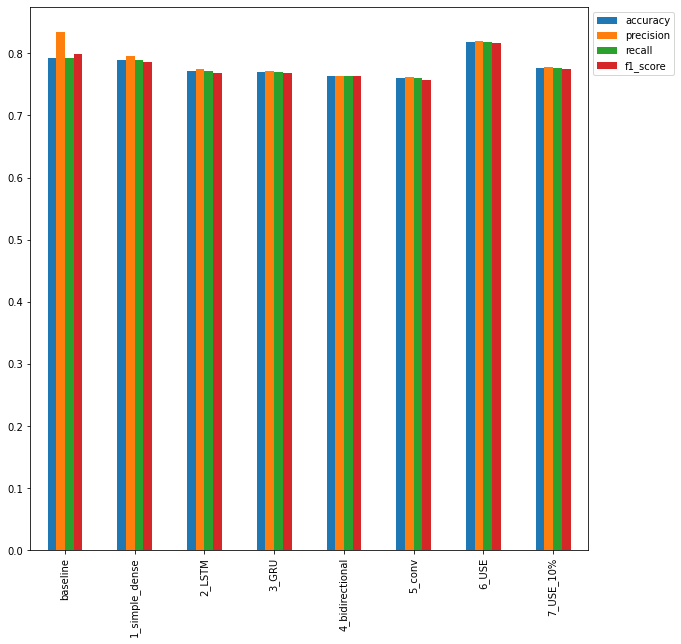

In [ ]:
all_models_results.plot(kind='bar', figsize=(10,10)).legend(bbox_to_anchor=(1.,1.))

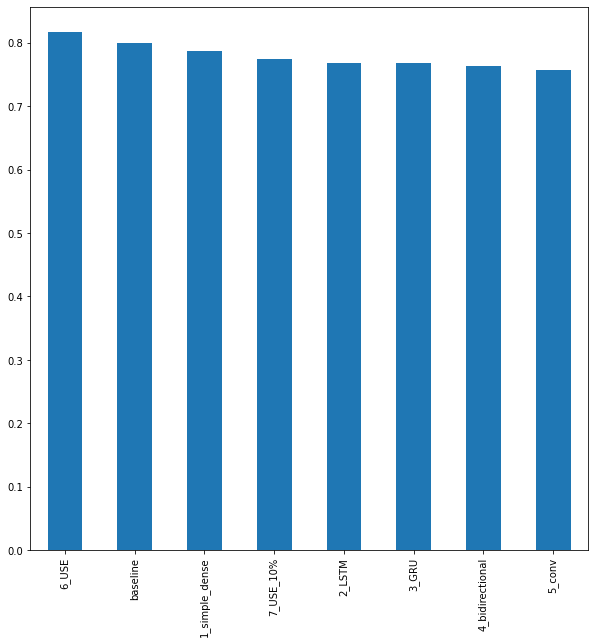

In [ ]:
all_models_results.sort_values('f1_score', ascending=False)["f1_score"].plot(kind="bar", figsize=(10,10))

# Tensorboard

In [ ]:
!!tensorboard dev upload \
  --logdir "/content/models_logs"\
  --name "NLP experimentig" \
  --description "tensorflow NLP getting started" \
  --one_shot

^C


['2023-01-21 07:13:24.710528: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected',
 '',
 '***** TensorBoard Uploader *****',
 '',
 'This will upload your TensorBoard logs to https://tensorboard.dev/ from',
 'the following directory:',
 '',
 '/content/models_logs',
 '',
 'This TensorBoard will be visible to everyone. Do not upload sensitive',
 'data.',
 '',
 "Your use of this service is subject to Google's Terms of Service",
 '<https://policies.google.com/terms> and Privacy Policy',
 "<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service",
 '<https://tensorboard.dev/policy/terms/>.',
 '',
 'This notice will not be shown again while you are logged into the uploader.',
 'To log out, run `tensorboard dev auth revoke`.',
 '',
 'Continue? (yes/NO) Traceback (most recent call last):',
 '  File "/usr/local/bin/tensorboard", line 8, in <module>',
 '    sys.exit(run_main())',
 '  File "/usr

# Save model

In [ ]:
model_6.save("model_6.h5")

In [ ]:
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4289 - accuracy: 0.8110


[0.4289169907569885, 0.8110235929489136]

In [ ]:
model_6_results

# Evaluating the best model

In [ ]:
! wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-01-22 20:19:41--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.145.128, 2a00:1450:4013:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  36.5MB/s    in 26s     

2023-01-22 20:20:07 (35.9 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/

In [ ]:
model_6_pre = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [ ]:
model_6_pre.evaluate(val_sentences, val_labels), model_6_results

24/24 [==============================] - 1s 12ms/step - loss: 0.4272 - accuracy: 0.8163


([0.42723119258880615, 0.8162729740142822],
 {'accuracy': 0.8175853018372703,
  'precision': 0.8193590184304181,
  'recall': 0.8175853018372703,
  'f1_score': 0.8162739196871377})

In [ ]:
model_6_pred_probs = tf.squeeze(model_6_pre.predict(val_sentences))
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

24/24 [==============================] - 1s 12ms/step


In [ ]:
val_sentences.shape, val_labels.shape, model_6_pred_probs[1]

((762,), (762,), <tf.Tensor: shape=(), dtype=float32, numpy=0.747162>)

In [ ]:
val_df = pd.DataFrame({
    "text": val_sentences,
    "target": val_labels,
    "pred": model_6_preds,
    "probs": model_6_pred_probs,
    "is_correct": val_labels == model_6_preds
})

In [ ]:
most_wrong = val_df[val_df["is_correct"] == False].sort_values("probs", ascending=False)
most_wrong.head()

,text,target,pred,probs,is_correct
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196,False
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982,False
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300,False
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835455,False
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213,False


In [ ]:
for row in most_wrong[:10].itertuples():
  _, text, target, pred, probs, _ = row
  print(f"target: {target}, pred: {pred}, prob: {probs*100:.2f}")
  print("Text: \n", text)
  print("\n_________\n")

target: 0, pred: 1.0, prob: 91.02
Text: 
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

_________

target: 0, pred: 1.0, prob: 87.70
Text: 
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

_________

target: 0, pred: 1.0, prob: 85.23
Text: 
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

_________

target: 0, pred: 1.0, prob: 83.55
Text: 
 Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

_________

target: 0, pred: 1.0, prob: 82.72
Text: 
 @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

_________

target: 0, pred: 1.0, prob: 81.48
Text: 
 @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

_________

target: 0, pred: 1.0, prob: 81.08

In [ ]:
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, probs, _ = row
  print(f"target: {target}, pred: {pred}, prob: {probs*100:.2f}")
  print("Text: \n", text)
  print("\n_________\n")

target: 1, pred: 0.0, prob: 6.73
Text: 
 @DavidVonderhaar At least you were sincere ??

_________

target: 1, pred: 0.0, prob: 5.51
Text: 
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

_________

target: 1, pred: 0.0, prob: 5.46
Text: 
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

_________

target: 1, pred: 0.0, prob: 5.46
Text: 
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy

_________

target: 1, pred: 0.0, prob: 4.96
Text: 
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

_________

target: 1, pred: 0.0, prob: 4.39
Text: 
 @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

_________

target: 1, pred: 0.0, prob: 4.21
Text: 
 I get to smoke my shit in peace

______

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [ ]:
test_sentences = test_df["text"].to_list()
test_sentences[:5]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan']

In [ ]:
sample_sentences = random.sample(test_sentences, 10)

for sample in sample_sentences:
  pred_prob = tf.squeeze(model_6_pre.predict([sample], verbose=0))
  pred = tf.round(pred_prob)
  print(f"Pred: {pred}, Prob: {pred_prob*100:.2f}")
  print("Text: \n", sample)
  print("\n_________\n")

In [ ]:
text = "there is a war between russia and ukraine"
pred = tf.squeeze(tf.round(model_6_pre.predict([text])))
print("A disaster" if pred == 1 else "Not a disaster")

1/1 [==============================] - 0s 45ms/step
A disaster


# Creating a function to measure the time of prediction

In [ ]:
from datetime import datetime as time

def measure_time(model, samples):
  start_time = time.now()
  model.predict(samples)
  end_time = time.now()
  total = end_time - start_time

  return total.total_seconds(), total.total_seconds()/len(samples)

In [ ]:
measure_time(model_6_pre, val_sentences)

24/24 [==============================] - 0s 11ms/step


(0.367086, 0.000481740157480315)

,accuracy,precision,recall,f1_score
baseline,0.792651,0.833602,0.792651,0.799083
1_simple_dense,0.790026,0.796472,0.790026,0.786626
2_LSTM,0.771654,0.774786,0.771654,0.768896
3_GRU,0.770341,0.771825,0.770341,0.768323
4_bidirectional,0.763780,0.763378,0.763780,0.763319
5_conv,0.759843,0.761544,0.759843,0.757458
6_USE,0.817585,0.819359,0.817585,0.816274
7_USE_10%,0.776903,0.778427,0.776903,0.775004
